# Load Data

In [24]:
import json
import torch
import random
from sklearn.preprocessing import LabelEncoder
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import DataLoader, Dataset
from torch import nn
import numpy as np
from scipy.linalg import inv
from torch.optim import Adam

In [25]:
seed_value=42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Load CLINC150

In [26]:
# Load the dataset
with open("clinc150_uci/data_full.json", "r") as file:
    data = json.load(file)
# Extracting data
train_data = data['train']
val_data = data['val']
test_data = data['test']

oos_train_data = data['oos_train']
oos_val_data = data['oos_val']
oos_test_data = data['oos_test']

# Get sentences and labels
train_sentences = [item[0] for item in train_data]
train_labels = [item[1] for item in train_data]

val_sentences = [item[0] for item in val_data]
val_labels = [item[1] for item in val_data]

test_sentences = [item[0] for item in test_data]
test_labels = [item[1] for item in test_data]

oos_train_sentences = [item[0] for item in oos_train_data]
oos_val_sentences = [item[0] for item in oos_val_data]
oos_test_sentences = [item[0] for item in oos_test_data]
model_name = "ce_model_bert_CLINC150.pth"

# BANKING77-OOS

In [27]:
# # Define the IntentExample class and load_intent_examples function as provided
# class IntentExample:
#     def __init__(self, text, label, do_lower_case):
#         self.original_text = text
#         self.text = text
#         self.label = label
#         if do_lower_case:
#             self.text = self.text.lower()

# def load_intent_examples(file_path, do_lower_case=True):
#     examples = []
#     with open(f'{file_path}/seq.in', 'r', encoding="utf-8") as f_text, open(f'{file_path}/label', 'r', encoding="utf-8") as f_label:
#         for text, label in zip(f_text, f_label):
#             e = IntentExample(text.strip(), label.strip(), do_lower_case)
#             examples.append(e)
#     return examples

# # Define paths to the dataset directories
# base_dir = 'Few-Shot-Intent-Detection/Datasets/BANKING77-OOS'
# paths = {
#     'train': f'{base_dir}/train',
#     'valid': f'{base_dir}/valid',
#     'test': f'{base_dir}/test',
#     'oos_val': f'{base_dir}/ood-oos/valid',
#     'oos_test': f'{base_dir}/ood-oos/test'
# }
# datasets = {key: load_intent_examples(path) for key, path in paths.items()}

# # Extract sentences and labels from the loaded datasets
# train_sentences = [e.text for e in datasets['train']]
# train_labels = [e.label for e in datasets['train']]

# val_sentences = [e.text for e in datasets['valid']]
# val_labels = [e.label for e in datasets['valid']]

# test_sentences = [e.text for e in datasets['test']]
# test_labels = [e.label for e in datasets['test']]

# oos_val_sentences = [e.text for e in datasets['oos_val']]
# oos_test_sentences = [e.text for e in datasets['oos_test']]
# model_name = "ce_model_bert_BANKING77.pth"


# SNIPS

In [28]:
# # Define the IntentExample class and load_intent_examples function as provided
# class IntentExample:
#     def __init__(self, text, label, do_lower_case):
#         self.original_text = text
#         self.text = text
#         self.label = label
#         if do_lower_case:
#             self.text = self.text.lower()

# def load_intent_examples(file_path, do_lower_case=True):
#     examples = []
#     with open(f'{file_path}/seq.in', 'r', encoding="utf-8") as f_text, open(f'{file_path}/label', 'r', encoding="utf-8") as f_label:
#         for text, label in zip(f_text, f_label):
#             e = IntentExample(text.strip(), label.strip(), do_lower_case)
#             examples.append(e)
#     return examples

# # Define paths to the dataset directories
# base_dir = 'Few-Shot-Intent-Detection/Datasets/SNIPS'
# paths = {
#     'train': f'{base_dir}/train',
#     'valid': f'{base_dir}/valid',
#     'test': f'{base_dir}/test'
# }
# datasets = {key: load_intent_examples(path) for key, path in paths.items()}

# # Extract sentences and labels from the loaded datasets
# train_sentences = [e.text for e in datasets['train']]
# train_labels = [e.label for e in datasets['train']]

# val_sentences = [e.text for e in datasets['valid']]
# val_labels = [e.label for e in datasets['valid']]

# test_sentences = [e.text for e in datasets['test']]
# test_labels = [e.label for e in datasets['test']]
# unique_scenarios = set(train_labels)
# oos_scenario = random.choice(list(unique_scenarios))

# # Separate out of scope data
# oos_train_data = [(s, l) for s, l in zip(train_sentences, train_labels) if l == oos_scenario]
# oos_val_data = [(s, l) for s, l in zip(val_sentences, val_labels) if l == oos_scenario]
# oos_test_data = [(s, l) for s, l in zip(test_sentences, test_labels) if l == oos_scenario]

# # Remove out of scope data from original sets
# train_data = [(s, l) for s, l in zip(train_sentences, train_labels) if l != oos_scenario]
# val_data = [(s, l) for s, l in zip(val_sentences, val_labels) if l != oos_scenario]
# test_data = [(s, l) for s, l in zip(test_sentences, test_labels) if l != oos_scenario]
# # Extract sentences and labels
# train_sentences = [item[0] for item in train_data]
# train_labels = [item[1] for item in train_data]

# val_sentences = [item[0] for item in val_data]
# val_labels = [item[1] for item in val_data]

# test_sentences = [item[0] for item in test_data]
# test_labels = [item[1] for item in test_data]

# oos_train_sentences = [item[0] for item in oos_train_data]
# oos_val_sentences = [item[0] for item in oos_val_data]
# oos_test_sentences = [item[0] for item in oos_test_data]
# model_name = "ce_model_bert_SNIP.pth"
# oos_scenario

# ROSTD

In [29]:
# from datasets import load_dataset

# dataset = load_dataset("cmaldona/Generalization-MultiClass-CLINC150-ROSTD", "rostd+")

# train_sentences = []
# train_labels = []
# val_sentences = []
# val_labels = []
# test_sentences = []
# test_labels = []
# oos_test_sentences = []

# # Extract training data
# for example in dataset['train']:
#     train_sentences.append(example['data'].lower())
#     train_labels.append(example['labels'])

# # Extract validation data
# for example in dataset['validation']:
#     val_sentences.append(example['data'].lower())
#     val_labels.append(example['labels'])

# # Extract test data and separate ID from OOS
# for example in dataset['test']:
#     if example['generalisation'] == 'ID':
#         test_sentences.append(example['data'].lower())
#         test_labels.append(example['labels'])
#     elif example['generalisation'] == 'near-OOD' or example['generalisation'] == 'far-OOD':# OOS
#         try:
#             oos_test_sentences.append(example['data'].lower())
#         except:
#             continue
            

# model_name = "ce_model_bert_ROSTD.pth"

# Encode Labels

In [30]:
label_encoder = LabelEncoder()
# Fit the label encoder and transform labels to integers
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_val_labels = label_encoder.fit_transform(val_labels)

# Tokenize our sentences and create Dataloaders

In [31]:
pretrained_model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
transformer_model = AutoModel.from_pretrained(pretrained_model_name)
tokenized_lengths = [len(tokenizer.encode(sentence, add_special_tokens=True)) for sentence in train_sentences]
max_length = max(tokenized_lengths)
print(f"Max length for tokenizer: {max_length}")

class TextDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(sentences, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# 2. Create the dataset
train_dataset = TextDataset(train_sentences, encoded_train_labels, tokenizer, max_length)
val_dataset = TextDataset(val_sentences, encoded_val_labels, tokenizer, max_length)


Max length for tokenizer: 33


# Define functions to encode our sentences

In [32]:
transformer_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer_model = transformer_model.to(device)
def encode_sentences(model, sentences, tokenizer=tokenizer, batch_size=256):
    model = model.to(device)
    sentence_embeddings = []

    # Process sentences in batches
    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i+batch_size]
        encoded_input = tokenizer(batch_sentences, return_tensors='pt', padding=True, truncation=True, max_length=512)
        
        # Move the batch to the same device as the model
        encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
        
        with torch.no_grad():
            model_output = model(**encoded_input)

        pooled_output = model_output.last_hidden_state.mean(dim=1)
        sentence_embeddings.append(pooled_output)

    # Concatenate all batched embeddings and move to CPU in one go
    sentence_embeddings_np = torch.cat(sentence_embeddings, dim=0).cpu().numpy()
    
    return sentence_embeddings_np

# Define our model

In [33]:
transformer_model = AutoModel.from_pretrained(pretrained_model_name)
import torch.nn as nn

class TextClassifier(nn.Module):
    def __init__(self, transformer_model, num_labels):
        super(TextClassifier, self).__init__()
        self.transformer = transformer_model
        self.classifier = nn.Linear(self.transformer.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask):
        # Get the output from the transformer model
        transformer_output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        # Pool the outputs into a single sentence vector
        # You can use `transformer_output.last_hidden_state.mean(dim=1)` for mean pooling
        # or `transformer_output.last_hidden_state.max(dim=1).values` for max pooling
        sentence_embedding = transformer_output.last_hidden_state.max(dim=1).values
        # Forward pass through the classifier layer
        return self.classifier(sentence_embedding)


# Initiallize everything else we needed

In [34]:
unique_intents = list(set(train_labels)) 
transformer_model = AutoModel.from_pretrained(pretrained_model_name)
transformer_model.to(device)
model = TextClassifier(transformer_model, len(unique_intents))
model.to(device)
optimizer = Adam(model.parameters(), lr=0.0003453918396852349)
training_losses = []
validation_losses = []
batch_size= 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
loss_function = nn.CrossEntropyLoss()

In [35]:
num_epochs = 18

# Training Loop!!!

In [36]:
best_val_loss = float('inf')
for epoch in range(num_epochs):
    # Training Phase
    model.train()  # Set the model to training mode
    total_train_loss = 0
    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
        optimizer.zero_grad()  # Zero the gradients
        predictions = model(input_ids, attention_mask)  # Forward pass
        loss = loss_function(predictions, labels) 
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_losses.append(avg_train_loss) 

    # Validation Phase
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():  # Disable gradient calculations
        for batch in val_dataloader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            predictions = model(input_ids, attention_mask) 
            loss = loss_function(predictions, labels)  # Compute loss
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_dataloader)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        # Save the model
        torch.save(model, model_name)
        print(f"Epoch {epoch+1}/{num_epochs}: Lower validation loss found. Model saved.")
    validation_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.5e}, Validation Loss: {avg_val_loss:.5e}")

Epoch 1/18: Lower validation loss found. Model saved.
Epoch 1/18, Training Loss: 5.03081e+00, Validation Loss: 5.05436e+00
Epoch 2/18: Lower validation loss found. Model saved.
Epoch 2/18, Training Loss: 5.02283e+00, Validation Loss: 5.05134e+00
Epoch 3/18: Lower validation loss found. Model saved.
Epoch 3/18, Training Loss: 5.02047e+00, Validation Loss: 5.04254e+00
Epoch 4/18: Lower validation loss found. Model saved.
Epoch 4/18, Training Loss: 5.01831e+00, Validation Loss: 5.03731e+00
Epoch 5/18: Lower validation loss found. Model saved.
Epoch 5/18, Training Loss: 5.01826e+00, Validation Loss: 5.03456e+00
Epoch 6/18: Lower validation loss found. Model saved.
Epoch 6/18, Training Loss: 5.01612e+00, Validation Loss: 5.03453e+00
Epoch 7/18, Training Loss: 5.01584e+00, Validation Loss: 5.03486e+00
Epoch 8/18: Lower validation loss found. Model saved.
Epoch 8/18, Training Loss: 5.01579e+00, Validation Loss: 5.03050e+00
Epoch 9/18, Training Loss: 5.01495e+00, Validation Loss: 5.03332e+00
E

# Calculate means and covariance matrix

In [37]:
# fine_model = torch.load(model_name)
# fine_model.eval()  # Put the model in evaluation mode
# fine_model = fine_model.to(device)

In [38]:
# get trasformer part of the model
fine_model = model.transformer

In [39]:
train_embeddings = encode_sentences(fine_model, train_sentences)
val_embeddings = encode_sentences(fine_model, val_sentences)
test_embeddings = encode_sentences(fine_model, test_sentences)
oos_val_embeddings = encode_sentences(fine_model, oos_val_sentences)
oos_test_embeddings = encode_sentences(fine_model, oos_test_sentences)

In [40]:
intent_means = {}
for encoded_label in np.unique(encoded_train_labels):
    # Find indices where the encoded label matches
    indices = np.where(encoded_train_labels == encoded_label)[0]
    
    # Calculate the mean embedding for the current intent
    intent_embeddings = train_embeddings[indices]
    intent_mean = np.mean(intent_embeddings, axis=0)
    
    # Use the encoded label as the dictionary key
    intent_means[encoded_label] = intent_mean

In [41]:
covariance = np.cov(train_embeddings, rowvar=False)
cov_inverse = inv(covariance)

In [42]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
from scipy.spatial import distance
from sklearn.metrics import average_precision_score

In [43]:
def min_mahalanobis_for_sample(sample, intent_means, cov_inverse):
    distances = [distance.mahalanobis(sample, mean, cov_inverse) for mean in intent_means.values()]
    return min(distances)

In [44]:
# Compute minimum Mahalanobis distances for samples in test_embeddings and oos_test_embeddings
val_scores = [min_mahalanobis_for_sample(sample, intent_means, cov_inverse) for sample in val_embeddings]
oos_val_scores = [min_mahalanobis_for_sample(sample, intent_means, cov_inverse) for sample in oos_val_embeddings]

# True binary labels: 0 for in-domain and 1 for OOD
y_true = [0] * len(val_scores) + [1] * len(oos_val_scores)

# Combine the scores
y_scores = val_scores + oos_val_scores

# Compute AUPR
aupr = average_precision_score(y_true, y_scores)
aupr

0.9975183823529412

In [45]:
# Compute minimum Mahalanobis distances for samples in test_embeddings and oos_test_embeddings
test_scores = [min_mahalanobis_for_sample(sample, intent_means, cov_inverse) for sample in test_embeddings]
oos_test_scores = [min_mahalanobis_for_sample(sample, intent_means, cov_inverse) for sample in oos_test_embeddings]

# True binary labels: 0 for in-domain and 1 for OOD
y_true = [0] * len(test_scores) + [1] * len(oos_test_scores)

# Combine the scores
y_scores = test_scores + oos_test_scores

# Compute AUPR
aupr = average_precision_score(y_true, y_scores)
aupr


0.16156553441140253

In [46]:
auroc = roc_auc_score(y_true, y_scores)
auroc

0.4617202222222222

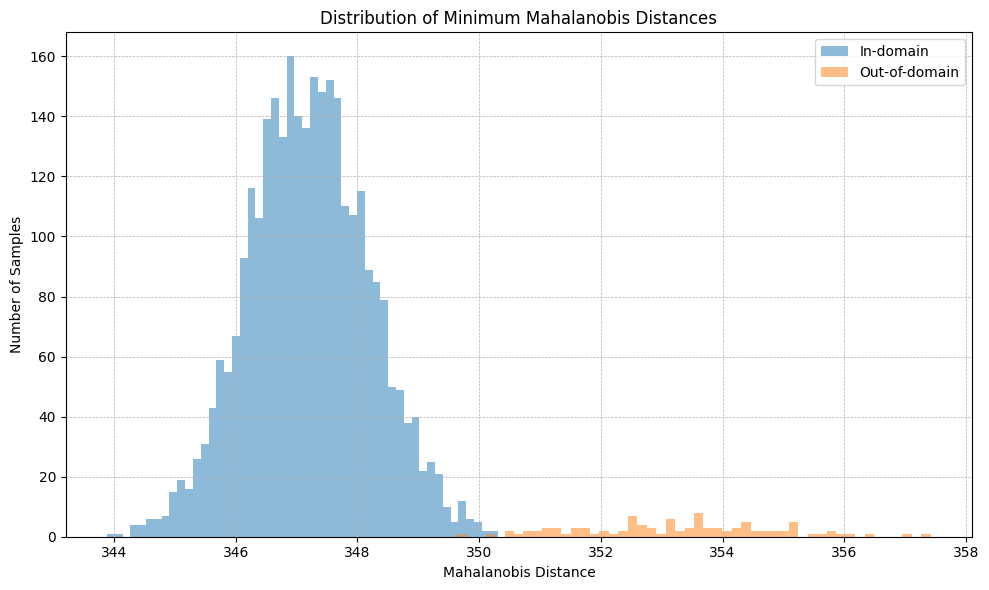

In [47]:
import matplotlib.pyplot as plt

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plot the histograms
plt.hist(val_scores, bins=50, alpha=0.5, label='In-domain')
plt.hist(oos_val_scores, bins=50, alpha=0.5, label='Out-of-domain')

# Add legend, title, and labels
plt.legend(loc='upper right')
plt.title('Distribution of Minimum Mahalanobis Distances')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Number of Samples')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()


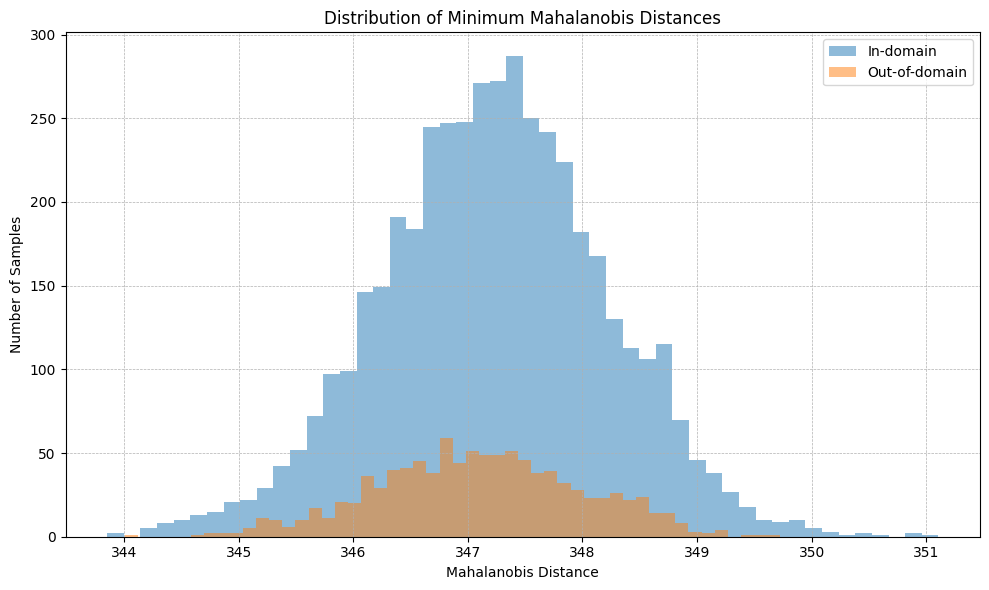

In [48]:
# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plot the histograms
plt.hist(test_scores, bins=50, alpha=0.5, label='In-domain')
plt.hist(oos_test_scores, bins=50, alpha=0.5, label='Out-of-domain')

# Add legend, title, and labels
plt.legend(loc='upper right')
plt.title('Distribution of Minimum Mahalanobis Distances')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Number of Samples')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import optuna
from transformers import AutoTokenizer, AutoModel

# Assuming other necessary imports are already there

def objective(trial):
    # Optuna suggests hyperparameters
    seed_value=42
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    lr = trial.suggest_float('lr', 5e-6,1e-3, log=True)
    num_epochs = trial.suggest_int('num_epochs', 5, 25)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])
    training_losses = []
    validation_losses = []
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    # Model setup
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
    transformer_model = AutoModel.from_pretrained(pretrained_model_name)
    model = TextClassifier(transformer_model, len(unique_intents))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    

    # Loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        # Training Phase
        model.train()  # Set the model to training mode
        total_train_loss = 0
        for batch in train_dataloader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            optimizer.zero_grad()  # Zero the gradients
            predictions = model(input_ids, attention_mask)  # Forward pass
            loss = loss_function(predictions, labels) 
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
    
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_dataloader)
        training_losses.append(avg_train_loss) 
    
        # Validation Phase
        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        with torch.no_grad():  # Disable gradient calculations
            for batch in val_dataloader:
                input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
                predictions = model(input_ids, attention_mask) 
                loss = loss_function(predictions, labels)  # Compute loss
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_dataloader)
        validation_losses.append(avg_val_loss)
    
    trial.set_user_attr("training_losses", training_losses)
    trial.set_user_attr("validation_losses", validation_losses)
    fine_transformer = model.transformer
    train_embeddings = encode_sentences(fine_transformer, train_sentences)
    val_embeddings = encode_sentences(fine_transformer, val_sentences)
    oos_val_embeddings = encode_sentences(fine_transformer, oos_val_sentences)

    intent_means = {}
    for encoded_label in np.unique(encoded_train_labels):
        # Find indices where the encoded label matches
        indices = np.where(encoded_train_labels == encoded_label)[0]
        
        # Calculate the mean embedding for the current intent
        intent_embeddings = train_embeddings[indices]
        intent_mean = np.mean(intent_embeddings, axis=0)
        
        # Use the encoded label as the dictionary key
        intent_means[encoded_label] = intent_mean
    covariance = np.cov(train_embeddings, rowvar=False)
    cov_inverse = inv(covariance)
    val_scores = [min_mahalanobis_for_sample(sample, intent_means, cov_inverse) for sample in val_embeddings]
    oos_val_scores = [min_mahalanobis_for_sample(sample, intent_means, cov_inverse) for sample in oos_val_embeddings]

    # True binary labels: 0 for in-domain and 1 for OOD
    y_true = [0] * len(val_scores) + [1] * len(oos_val_scores)

    # Combine the scores
    y_scores = val_scores + oos_val_scores

    # Compute AUPR
    aupr = average_precision_score(y_true, y_scores)
    
    return aupr

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize',  study_name='ce_loss_CLINC150', storage='sqlite:///desperate.db', load_if_exists= True)
study.optimize(objective, n_trials=1000)  # n_trials is the number of iterations

# Get the best parameters
best_params = study.best_params
print("Best parameters:", best_params)



[I 2024-02-13 02:05:16,258] Using an existing study with name 'ce_loss_CLINC150' instead of creating a new one.
[I 2024-02-13 03:09:26,649] Trial 3 finished with value: 0.5137050790078099 and parameters: {'lr': 7.359193126938965e-05, 'num_epochs': 24, 'batch_size': 32, 'ed_loss_importance': 0.3910406167783932}. Best is trial 3 with value: 0.5137050790078099.
[I 2024-02-13 03:23:11,876] Trial 7 finished with value: 0.7763059204874113 and parameters: {'lr': 1.1846373186806515e-05, 'num_epochs': 15, 'batch_size': 256, 'ed_loss_importance': 0.4301329249883552}. Best is trial 7 with value: 0.7763059204874113.
[I 2024-02-13 03:56:54,583] Trial 8 finished with value: 1.0 and parameters: {'lr': 0.0003021585911474091, 'num_epochs': 23, 'batch_size': 64, 'ed_loss_importance': 0.8575073090347524}. Best is trial 8 with value: 1.0.
[I 2024-02-13 04:10:17,013] Trial 10 finished with value: 0.4822616819737264 and parameters: {'lr': 0.00032581134748499533, 'num_epochs': 16, 'batch_size': 256, 'ed_loss